In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import sklearn
import seaborn as sn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from k_means import *

### Data loading

In [3]:
root = "/media/dikra/PhD/DATA/DLC24_Data/tiny_all_bird_merged_coco"
images = f"{root}/images"
annotations = f"{root}/annotations"

In [4]:
train_file = open(f"{annotations}/train.json")
test_file = open(f"{annotations}/test.json")
train_data = json.load(train_file)
test_data = json.load(test_file)

In [5]:
train_ann = len(train_data["annotations"])
f"{train_ann} Annotated train images"

'414 Annotated train images'

In [6]:
cats = train_data["categories"][0]["keypoints"]
cats_dict = dict(zip(range(0, len(cats)), cats))
cats_dict

{0: 'back',
 1: 'bill',
 2: 'belly',
 3: 'breast',
 4: 'crown',
 5: 'forehead',
 6: 'left_eye',
 7: 'left_leg',
 8: 'left_wing_tip',
 9: 'left_wrist',
 10: 'nape',
 11: 'right_eye',
 12: 'right_leg',
 13: 'right_wing_tip',
 14: 'right_wrist',
 15: 'tail_tip',
 16: 'throat',
 17: 'neck',
 18: 'tail_left',
 19: 'tail_right',
 20: 'upper_spine',
 21: 'upper_half_spine',
 22: 'lower_half_spine',
 23: 'right_foot',
 24: 'left_foot',
 25: 'left_half_chest',
 26: 'right_half_chest',
 27: 'chin',
 28: 'left_tibia',
 29: 'right_tibia',
 30: 'lower_spine',
 31: 'upper_half_neck',
 32: 'lower_half_neck',
 33: 'left_chest',
 34: 'right_chest',
 35: 'upper_neck',
 36: 'left_wing_shoulder',
 37: 'left_wing_elbow',
 38: 'right_wing_shoulder',
 39: 'right_wing_elbow',
 40: 'upper_cere',
 41: 'lower_cere'}

### Data prep

In [7]:
all_keypoints = get_all_keypoints(train_data)  # load all keypoint annotations
parsed_keypoints = keypoint2vec(all_keypoints)  # parse keypoint annotations into (x, y, visibility) triples
# indexed_keypoints = get_keypoints_dict(parsed_keypoints)  # index keypoint with corresponding body part
# visible_keypoints = get_visible_keypoints(indexed_keypoints)  # filter out invisible & occluded keypoints (keeping 1. and 2. visibility)
# features = get_features(visible_keypoints)  # turn dict into pandas dataframe for kmeans & visualisation manipulations
# f"{len(features)} visible annotated keypoints"
parsed_keypoints, parsed_keypoints.shape

(array([[  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        ...,
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [514., 304.,   0., ...,   0.,   0.,   0.],
        [368., 162.,   0., ...,   0.,   0.,   0.]]),
 (414, 126))

In [8]:
df = pd.DataFrame(parsed_keypoints)
df.sample(5)

,0,1,2,3,4,5,6,7,8,9,...,116,117,118,119,120,121,122,123,124,125
68,0.0,0.0,0.0,1446.0,352.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,0.0,0.0,0.0,1312.0,1080.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
57,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
348,545.0,298.0,0.0,836.0,318.0,0.0,600.0,506.0,0.0,698.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98,0.0,0.0,0.0,101.0,372.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
df = df.loc[:, (df != 0).any(axis=0)]

In [10]:
df

,0,1,3,4,5,6,7,9,10,12,...,49,51,52,53,69,70,71,72,73,74
0,0.0,0.0,160.0,358.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,168.0,364.0,2.0,168.0,399.0,2.0,182.0,399.0,2.0
1,0.0,0.0,257.0,328.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,271.0,339.0,2.0,279.0,387.0,2.0,289.0,389.0,2.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,353.0,334.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,391.0,325.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,375.0,367.0,2.0,367.0,364.0,2.0
4,0.0,0.0,426.0,332.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,420.0,337.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409,364.0,410.0,139.0,186.0,0.0,357.0,639.0,293.0,469.0,290.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
410,437.0,208.0,657.0,210.0,0.0,422.0,408.0,526.0,333.0,553.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
411,0.0,0.0,305.0,156.0,0.0,238.0,182.0,266.0,158.0,293.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
412,514.0,304.0,328.0,271.0,0.0,538.0,415.0,435.0,382.0,429.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
cov = np.corrcoef(df.T)

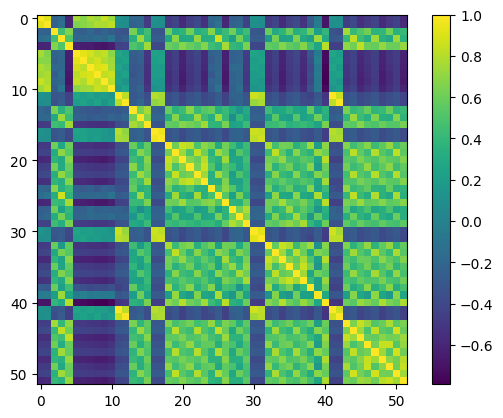

In [12]:
plt.imshow(cov)
plt.colorbar()

In [13]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df)

In [14]:
pca = PCA(n_components=3)
p_comp = pca.fit_transform(scaled_features)

### KMeans clustering

In [15]:
n_clusters = 3 # len(cats)

scaled_features, centers, predicted_labels = keypoint_kmeans(n_clusters, p_comp)

In [16]:
# Construct dataframe from predicted clusters
predicted_clusters = to_df(scaled_features, predicted_labels)
predicted_clusters

,0,1,2,label
0,-0.001362,0.234341,-0.423852,0
0,0.491494,0.172079,-0.121100,0
0,-0.080789,0.269060,-0.745161,0
0,0.269224,0.258939,-0.587291,0
0,0.054381,0.215999,-0.693763,0
...,...,...,...,...
2,-0.896433,-1.682781,0.087630,2
2,-0.884493,-1.564758,-0.123444,2
2,-0.670028,-0.503214,-0.588113,2
2,-0.928208,-1.682787,-0.148521,2


In [17]:
import plotly.express as px

fig = px.scatter_3d(predicted_clusters, x=0, y=1, z=2, color='label')
fig.show()

Text(0.5, 1.0, 'Train keypoints: 3 clusters')

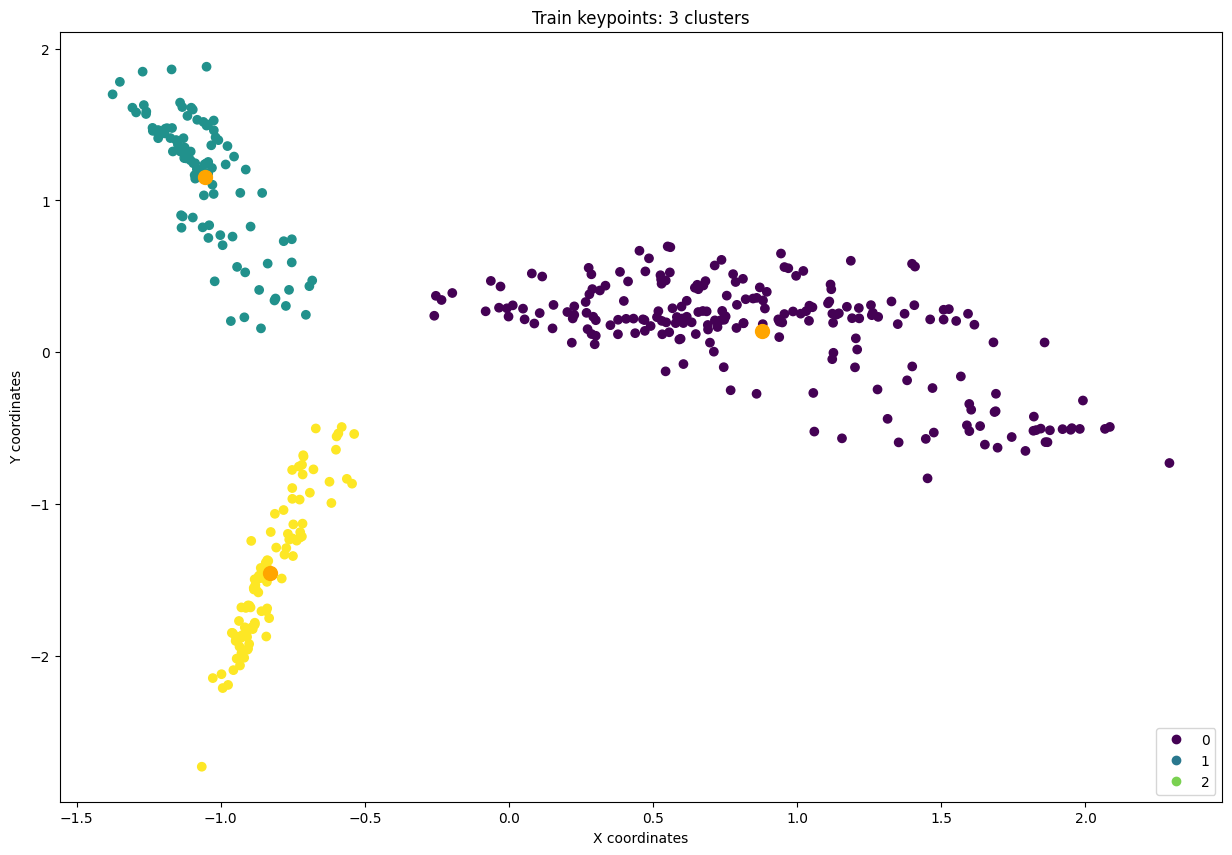

In [18]:
plt.figure(figsize=(15, 10))
scatter = plt.scatter(
    predicted_clusters[0], predicted_clusters[1], c=predicted_clusters["label"]
)
scatter2 = plt.scatter(centers[:, 0], centers[:, 1], c="orange", s=100)
plt.xlabel("X coordinates")
plt.ylabel("Y coordinates")

unique_labels = np.unique(predicted_clusters["label"])
handles, labels = scatter.legend_elements(prop="colors", num=len(unique_labels))
plt.legend(
    handles, unique_labels, loc="lower right", ncol=len(unique_labels) / n_clusters
)
plt.title(f"Train keypoints: {n_clusters} clusters")